In [3]:
import os
import glob
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torchvision import models
import numpy as np

In [4]:
class EarDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label


In [5]:
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.4),
    A.Rotate(limit=30, p=0.6),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.ElasticTransform(p=0.3),
    A.GridDistortion(p=0.2),
    A.CoarseDropout(max_holes=1, max_height=40, max_width=40, p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-5-2651380383.py:10: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=40, max_width=40, p=0.3),


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_dir = "/content/drive/MyDrive/Dataset1/images"
known_classes = ['000', '001', '002', '003', '004', '005', '006', '007', '011', '012']
unknown_classes = ['008', '009', '010']
all_classes = known_classes + unknown_classes
label_dict = {name: idx for idx, name in enumerate(all_classes)}


In [7]:
image_paths = []
labels = []
for class_name in known_classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_path in glob.glob(os.path.join(class_path, "*.png")):
            image_paths.append(img_path)
            labels.append(label_dict[class_name])

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

train_dataset = EarDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = EarDataset(val_paths, val_labels, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
unknown_paths = []
unknown_labels = []
for class_name in unknown_classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_path in glob.glob(os.path.join(class_path, "*.png")):
            unknown_paths.append(img_path)
            unknown_labels.append(label_dict[class_name])

unknown_dataset = EarDataset(unknown_paths, unknown_labels, transform=val_transforms)
unknown_loader = DataLoader(unknown_dataset, batch_size=32, shuffle=False)


In [12]:
from tqdm import tqdm
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=3):
    best_val_loss = float('inf')
    trigger_times = 0
    best_model_state_dict = copy.deepcopy(model.state_dict())

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    device = next(model.parameters()).device

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item(), acc=correct / total)

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss /= len(val_loader)

        scheduler.step()
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # ✅ Epoch Summary
        print(f"✅ Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

        # 💡 Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = copy.deepcopy(model.state_dict())
            trigger_times = 0
            print("📈 Validation loss improved — model saved.")
        else:
            trigger_times += 1
            print(f"⚠️ No improvement for {trigger_times} epoch(s).")

            if trigger_times >= patience:
                print("⏹️ Early stopping triggered.")
                break

    # 🔄 Restore best model weights
    model.load_state_dict(best_model_state_dict)
    return model, history


In [13]:
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch

# Get number of classes from train_labels
num_classes = len(set(train_labels))

# Load pretrained EfficientNet and modify final layer
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function (CrossEntropy is good for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
model, history = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    num_epochs=20, patience=3
)


✅ Epoch 1/20 | Train Acc: 0.9425, Val Acc: 0.9950, Val Loss: 0.0294
📈 Validation loss improved — model saved.


✅ Epoch 2/20 | Train Acc: 0.9663, Val Acc: 0.9975, Val Loss: 0.0260
📈 Validation loss improved — model saved.


✅ Epoch 3/20 | Train Acc: 0.9656, Val Acc: 1.0000, Val Loss: 0.0075
📈 Validation loss improved — model saved.


✅ Epoch 4/20 | Train Acc: 0.9838, Val Acc: 1.0000, Val Loss: 0.0015
📈 Validation loss improved — model saved.


✅ Epoch 5/20 | Train Acc: 0.9919, Val Acc: 1.0000, Val Loss: 0.0012
📈 Validation loss improved — model saved.


✅ Epoch 6/20 | Train Acc: 0.9925, Val Acc: 1.0000, Val Loss: 0.0007
📈 Validation loss improved — model saved.


✅ Epoch 7/20 | Train Acc: 0.9956, Val Acc: 1.0000, Val Loss: 0.0005
📈 Validation loss improved — model saved.


✅ Epoch 8/20 | Train Acc: 0.9975, Val Acc: 1.0000, Val Loss: 0.0004
📈 Validation loss improved — model saved.


✅ Epoch 9/20 | Train Acc: 0.9962, Val Acc: 1.0000, Val Loss: 0.0002
📈 Validation loss improved — model saved.


✅ Epoch 10/20 | Train Acc: 0.9981, Val Acc: 1.0000, Val Loss: 0.0005
⚠️ No improvement for 1 epoch(s).


✅ Epoch 11/20 | Train Acc: 0.9981, Val Acc: 1.0000, Val Loss: 0.0002
⚠️ No improvement for 2 epoch(s).


✅ Epoch 12/20 | Train Acc: 0.9950, Val Acc: 1.0000, Val Loss: 0.0002
📈 Validation loss improved — model saved.


✅ Epoch 13/20 | Train Acc: 0.9969, Val Acc: 1.0000, Val Loss: 0.0003
⚠️ No improvement for 1 epoch(s).


✅ Epoch 14/20 | Train Acc: 0.9950, Val Acc: 1.0000, Val Loss: 0.0005
⚠️ No improvement for 2 epoch(s).


✅ Epoch 15/20 | Train Acc: 0.9969, Val Acc: 1.0000, Val Loss: 0.0024
⚠️ No improvement for 3 epoch(s).
⏹️ Early stopping triggered.


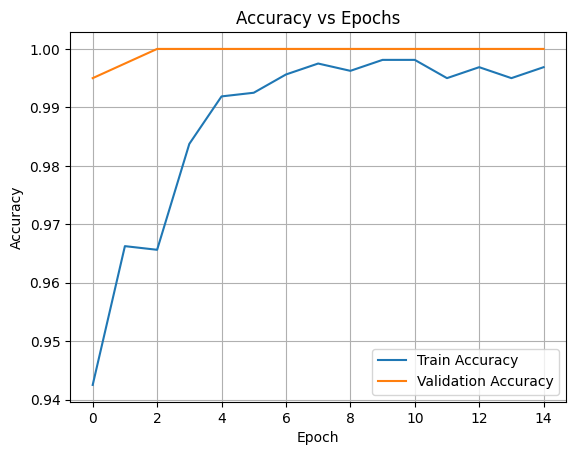

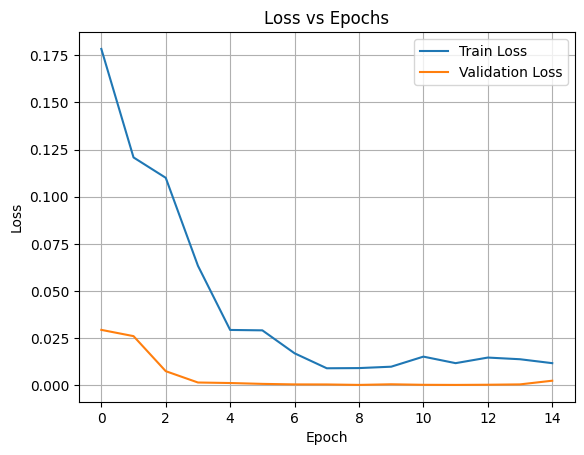

In [16]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, val_loader, class_names):
    model.eval()
    device = next(model.parameters()).device
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Report
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


Classification Report:
               precision    recall  f1-score   support

         000       1.00      1.00      1.00        40
         001       1.00      1.00      1.00        40
         002       1.00      1.00      1.00        40
         003       1.00      1.00      1.00        40
         004       1.00      1.00      1.00        40
         005       1.00      1.00      1.00        40
         006       1.00      1.00      1.00        40
         007       1.00      1.00      1.00        40
         011       1.00      1.00      1.00        40
         012       1.00      1.00      1.00        40

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



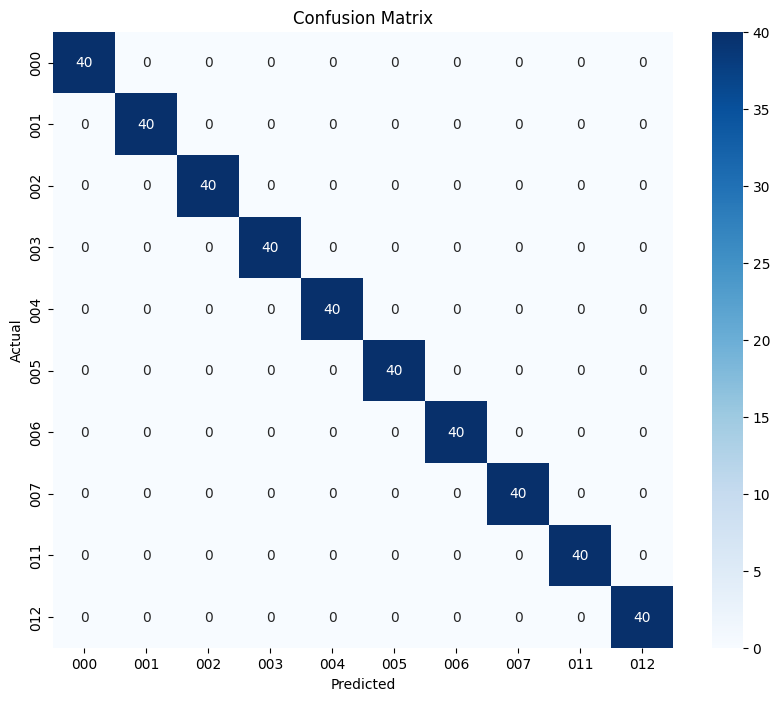

In [18]:
class_names = ['000', '001', '002', '003', '004', '005', '006', '007', '011', '012']  # or your class labels
evaluate_model(model, val_loader, class_names)

In [25]:
mavs, class_features = compute_mavs(model, train_loader, num_classes)
weibull_models = fit_weibull(mavs, class_features, tail_size=20)


Computing MAVs: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


In [26]:
import numpy as np
from tqdm import tqdm

def compute_mavs(model, dataloader, num_classes):
    model.eval()
    class_features = {i: [] for i in range(num_classes)}

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Computing MAVs"):
            images, labels = images.to(device), labels.to(device)
            features = model.features(images)  # before classifier
            pooled = model.avgpool(features)
            flat = torch.flatten(pooled, 1)

            for i in range(images.size(0)):
                class_features[labels[i].item()].append(flat[i].cpu().numpy())

    mavs = {cls: np.mean(vectors, axis=0) for cls, vectors in class_features.items()}
    return mavs, class_features


In [27]:
from scipy.stats import weibull_min

def fit_weibull(mavs, class_features, tail_size=20):
    weibull_models = {}
    for cls, mav in mavs.items():
        distances = [np.linalg.norm(vec - mav) for vec in class_features[cls]]
        tail = sorted(distances)[-tail_size:]
        shape, loc, scale = weibull_min.fit(tail, floc=0)
        weibull_models[cls] = (shape, scale)
    return weibull_models



In [28]:
import torch.nn.functional as F

def openmax_recalibrate(logits, feature_vec, mavs, weibull_models, alpha=10):
    num_classes = len(mavs)
    softmax_scores = F.softmax(torch.from_numpy(logits), dim=0).numpy()

    ranked = sorted(range(len(mavs)), key=lambda x: softmax_scores[x], reverse=True)[:alpha]

    unknown_score = 0.0
    revised_scores = np.zeros(num_classes)

    for cls in range(num_classes):
        dist = np.linalg.norm(feature_vec - mavs[cls])
        shape, scale = weibull_models[cls]
        w_score = weibull_min.cdf(dist, shape, loc=0, scale=scale)
        w = 1 - w_score

        if cls in ranked:
            revised_scores[cls] = softmax_scores[cls] * w
            unknown_score += softmax_scores[cls] * (1 - w)
        else:
            revised_scores[cls] = softmax_scores[cls]

    final_scores = np.append(revised_scores, unknown_score)
    openmax_probs = F.softmax(torch.from_numpy(final_scores), dim=0).numpy()
    return openmax_probs


In [29]:
unknown_openmax_preds = []
unknown_openmax_probs = []

model.eval()
with torch.no_grad():
    for images, labels in unknown_loader:
        images = images.to(device)
        features = model.features(images)
        pooled = model.avgpool(features)
        flat = torch.flatten(pooled, 1)
        logits = model.classifier(flat)

        for i in range(images.size(0)):
            logit = logits[i].cpu().numpy()
            emb = flat[i].cpu().numpy()
            prob = openmax_recalibrate(logit, emb, mavs, weibull_models)
            pred = np.argmax(prob)
            unknown_openmax_preds.append(pred)
            unknown_openmax_probs.append(prob)


In [30]:
# Unknown class is at index len(mavs)
unknown_class_idx = len(mavs)
openmax_detected = sum(1 for p in unknown_openmax_preds if p == unknown_class_idx)
openmax_rate = openmax_detected / len(unknown_openmax_preds)
print(f"🔍 OpenMax Unknown Detection Rate: {openmax_rate:.2%}")


🔍 OpenMax Unknown Detection Rate: 92.00%


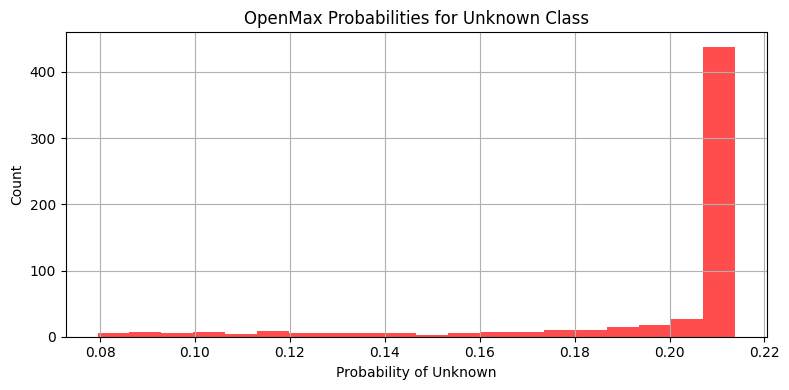

In [31]:
import matplotlib.pyplot as plt

unknown_probs = [p[len(mavs)] for p in unknown_openmax_probs]  # last index = unknown class

plt.figure(figsize=(8, 4))
plt.hist(unknown_probs, bins=20, color='red', alpha=0.7)
plt.title("OpenMax Probabilities for Unknown Class")
plt.xlabel("Probability of Unknown")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


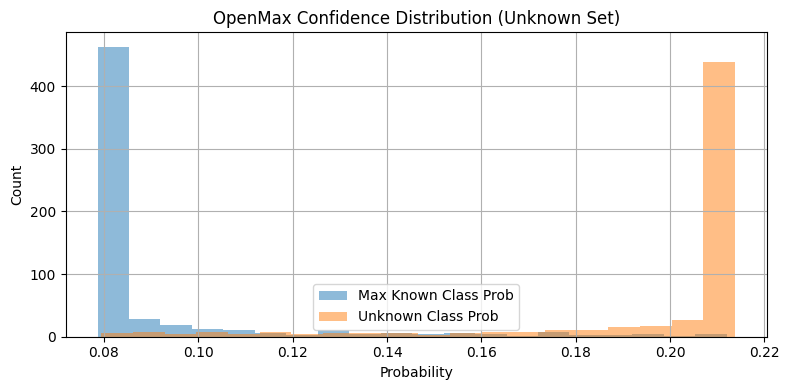

In [32]:


plt.figure(figsize=(8, 4))
plt.hist([max(p[:-1]) for p in unknown_openmax_probs], bins=20, alpha=0.5, label='Max Known Class Prob')
plt.hist([p[-1] for p in unknown_openmax_probs], bins=20, alpha=0.5, label='Unknown Class Prob')
plt.title("OpenMax Confidence Distribution (Unknown Set)")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
val_paths, test_paths, val_labels, test_labels = train_test_split(
    val_paths, val_labels, test_size=0.5, stratify=val_labels, random_state=42
)
test_dataset = EarDataset(test_paths, test_labels, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [37]:
test_embeddings = []
test_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        features = model.features(images)
        pooled = model.avgpool(features)
        flattened = torch.flatten(pooled, 1)

        test_embeddings.append(flattened.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Convert to numpy array
test_embeddings_euc = np.vstack(test_embeddings)  # final Euclidean embeddings
test_labels = np.array(test_labels)
unknown_embeddings = []

with torch.no_grad():
    for images, _ in unknown_loader:
        images = images.to(device)
        features = model.features(images)
        pooled = model.avgpool(features)
        flattened = torch.flatten(pooled, 1)
        unknown_embeddings.append(flattened.cpu().numpy())

unknown_embeddings_euc = np.vstack(unknown_embeddings)


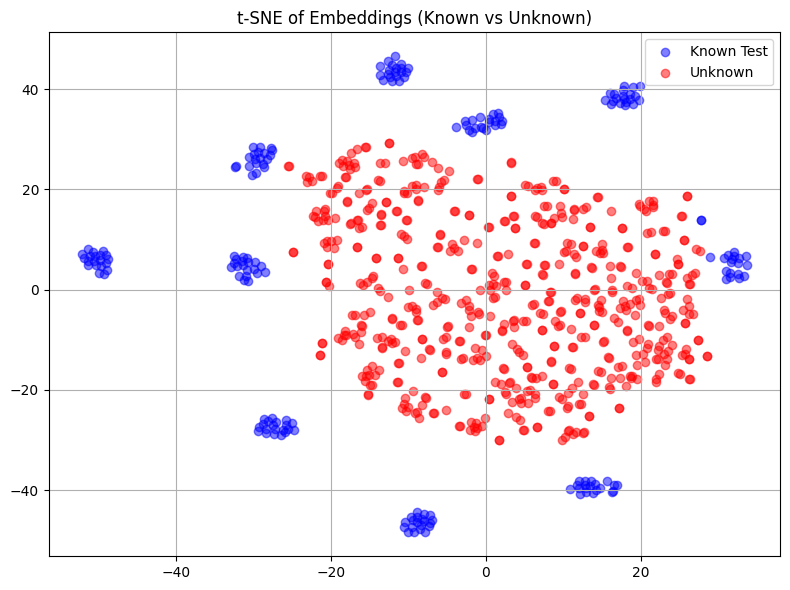

In [38]:
from sklearn.manifold import TSNE
import numpy as np

# Combine known + unknown embeddings
all_embeddings = np.concatenate([test_embeddings_euc, unknown_embeddings_euc], axis=0)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_embeddings)

# Split
n_known = len(test_embeddings_euc)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:n_known, 0], tsne_result[:n_known, 1], c='blue', label='Known Test', alpha=0.5)
plt.scatter(tsne_result[n_known:, 0], tsne_result[n_known:, 1], c='red', label='Unknown', alpha=0.5)
plt.title("t-SNE of Embeddings (Known vs Unknown)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


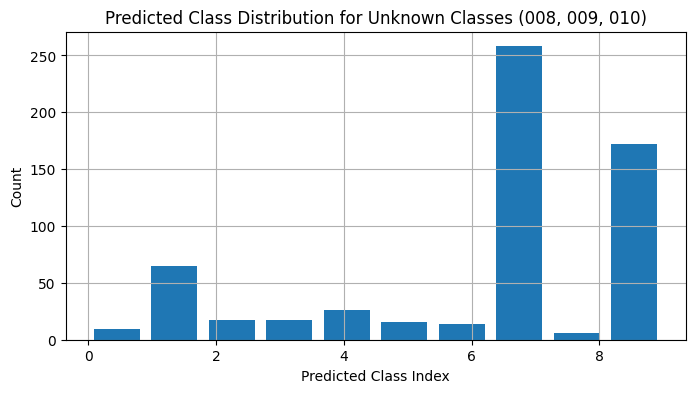

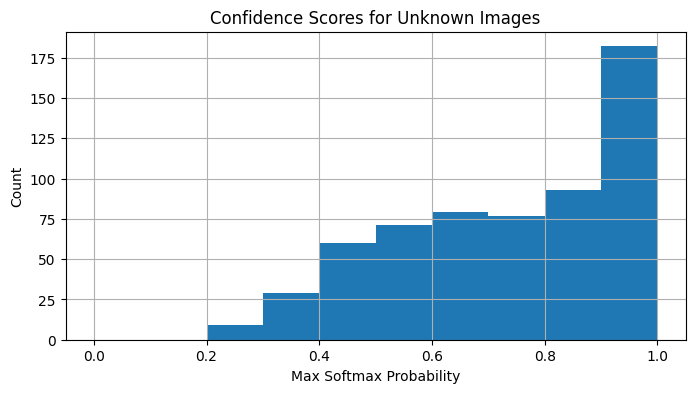

Unknown Detection Rate (confidence < 0.7): 54.17%


In [19]:
#softmax

import torch.nn.functional as F
unknown_preds = []
unknown_confidences = []
unknown_true_labels = []

model.eval()
with torch.no_grad():
    for images, labels in unknown_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        unknown_preds.extend(preds.cpu().numpy())
        unknown_confidences.extend(max_probs.cpu().numpy())
        unknown_true_labels.extend(labels.cpu().numpy())

plt.figure(figsize=(8, 4))
plt.hist(unknown_preds, bins=len(set(train_labels)), rwidth=0.8)
plt.title("Predicted Class Distribution for Unknown Classes (008, 009, 010)")
plt.xlabel("Predicted Class Index")
plt.ylabel("Count")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(unknown_confidences, bins=10, range=(0, 1))
plt.title("Confidence Scores for Unknown Images")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Count")
plt.grid(True)
plt.show()

unknown_flagged = [1 if conf < 0.8 else 0 for conf in unknown_confidences]
unknown_detected_rate = sum(unknown_flagged) / len(unknown_flagged)
print(f"Unknown Detection Rate (confidence < 0.7): {unknown_detected_rate:.2%}")